# Supplementary Information:

> **"Background-dependent effects of selection on subclonal heterogeneity"**

> Ignacio Vázquez-García, Francisco Salinas, Jing Li, Andrej Fischer, Benjamin Barré, Johan Hallin, Anders Bergström, Elisa Alonso-Pérez, Jonas Warringer, Ville Mustonen, Gianni Liti

## Figure 3 (+ Supp. Figs.)

This IPython notebook is provided for reproduction of Figures 3, S5 and S6 of the paper. It can be viewed by copying its URL to nbviewer and it can be run by opening it in binder.

In [1]:
# load external dependencies
import matplotlib.gridspec as gridspec
from matplotlib import pyplot as plt
import matplotlib as mpl
import matplotlib.lines as lines
import matplotlib.patches as patches
import matplotlib.patheffects as PathEffects
%matplotlib inline

import json,matplotlib
s = json.load( open("matplotlibrc.json") )
matplotlib.rcParams.update(s)

import numpy as np
from scipy import stats
import pandas as pd # (*) Pandas for data manipulation

# load internal dependencies
import colors,plot,utils,config

# absolute file path for root directory of git repo
dir_repo = utils.get_git_path()
dir_data = dir_repo+"/data/"
dir_paper = dir_repo+"/manuscript/main/"
dir_supp = dir_repo+"/manuscript/supp/"

%load_ext autoreload
%autoreload 2

import warnings

with warnings.catch_warnings():
    warnings.filterwarnings("ignore")

## Data import

### Chromosome length

In [2]:
chr_coords = utils.chr_coords(dir_data+'seq/chr_coords.txt')

chr_coords.head()

,chr_arabic,chr_length,chr_start,chr_end
0,1,230218,0,230219
1,2,813184,230218,1043404
2,3,316620,1043402,1360025
3,4,1531933,1360022,2891959
4,5,576874,2891955,3468834


### Ancestral and evolved isolate genomes

* *De novo* SNPs and indels in ancestral and evolved isolate genomes

In [3]:
# load data
seq_mut_df = utils.load_data(dir_data+'seq/de-novo/seq_de_novo_snps_indels.pickle')

seq_mut_df = seq_mut_df.rename(columns={'chrom':'chr_arabic', 'pos':'site'})
seq_mut_df['chr_roman'] = seq_mut_df['chr_arabic'].apply(utils.int_to_roman)
seq_mut_df = utils.chr_to_gw(seq_mut_df, chr_coords)

seq_mut_df = seq_mut_df[(seq_mut_df.clone!='')].reset_index(drop=True)

# remap genotype values
seq_mut_df['genotype'] = seq_mut_df['genotype'].map({'0': 0, '1': 2,'0/0': 0, '0/1': 1, '1/0': 1, '1/1': 2})

seq_mut_df['type'] = 'de novo'

seq_mut_df.head()

,ac,af,alt,an,allele,amino_acids,biotype,baseqranksum,cds_position,chr_arabic,...,population,coverage,substitution,assignment,mutation_type,consequence_short,chr_roman,chr_length,pos,type
0,1,0.5,[A],2.0,A,R/I,protein_coding,1.723,101,7,...,WAxNA_F12_1_HU_1,28.795032,C>A,bulk,driver,non-synonymous,VII,1090940,4595191.0,de novo
1,1,0.5,[C],2.0,NaN,NaN,NaN,-0.34,NaN,4,...,WAxNA_F12_1_HU_1,28.795032,A>C,bulk,passenger,NaN,IV,1531933,2849276.0,de novo
2,1,0.5,[A],2.0,A,C/F,protein_coding,-1.488,1883,10,...,WAxNA_F12_1_HU_1,28.795032,C>A,bulk,passenger,non-synonymous,X,745751,5980969.0,de novo
3,1,0.5,[T],2.0,NaN,NaN,NaN,-0.653,NaN,13,...,WAxNA_F12_1_HU_1,28.795032,C>T,bulk,passenger,NaN,XIII,924431,8949297.0,de novo
4,1,0.5,[C],2.0,C,C/W,protein_coding,1.674,477,13,...,WAxNA_F12_1_HU_1,28.795032,A>C,bulk,passenger,non-synonymous,XIII,924431,9157827.0,de novo


* *De novo* SVs in ancestral and evolved isolate genomes

In [4]:
# Regular expression matching files to parse
pattern = dir_data+'seq/de-novo/sv/*T32_C*.sv.txt'
# pattern = '/Users/ivg/projects/yeast-cancer-drugs/*sv.txt'

import os, glob
def load_sequence_data(pattern):

    # Load variant calls
    df = {}
    
    for ii, vcf_fn in enumerate(glob.glob(pattern)):
        
        fn = vcf_fn.split('/')
        sample = fn[-1].split('.')[0]
        variant_type = fn[-1].split('.')[1]
        
        # Load variant calls
        if os.stat(vcf_fn).st_size != 0:
            seq = pd.read_csv(vcf_fn, sep='\t')
            df[(sample,variant_type)] = pd.DataFrame(seq)

    # Concatenate dict of dataframes, one per sample
    df = pd.concat(df, names=['sample','variant_type']).reset_index(level='sample')

    # Clean up sample names
    df['sample'] = df['sample'].replace({'WA-WA':'WA/WA','NA-NA':'NA/NA','WA-NA':'WA/NA'}, regex=True)

    return df

def clean_sequence_data(df):
    
    # 
    df['chr'] = df['chr'].apply(lambda x: x.replace('chr','')).astype(int)
    df['chr2'] = df['chr2'].apply(lambda x: x.replace('chr','')).astype(int)
    
    # Get cumulative coordinates
    df, _ = utils.est_cum_pos(position=df, aggregation='chr', column='start', offset=0, chrom_len=config.chrom_len)
    df, _ = utils.est_cum_pos(position=df, aggregation='chr2', column='end', offset=0, chrom_len=config.chrom_len)
    
    return df

seq_sv_df = load_sequence_data(pattern)
seq_sv_df = clean_sequence_data(seq_sv_df)

seq_sv_df['selection'] = seq_sv_df['sample'].apply(lambda x: x.split('_')[3])
seq_sv_df['population'] = seq_sv_df['sample'].apply(lambda x: '_'.join(x.split('_')[:-1] ))
seq_sv_df['isolate'] = seq_sv_df['sample'].apply(lambda x: x.split('_')[-1])

seq_sv_df[['chr','start','start_cum','chr2','end','end_cum']].head()

AttributeError: 'tuple' object has no attribute 'append'

* Background (consensus) and *de novo* SNPs and indels
* Copy number variation
* Loss-of-heterozygosity

In [4]:
# load data
seq_loh_df = utils.load_data(dir_data+'seq/de-novo/seq_de_novo_loh.pickle')

seq_loh_df.head()

,selection,population,sample,time,set,clone,lineage,type,chr_arabic,chr_roman,start,end,length,pos,genotype,ploidy,gene
65038,HU,WAxNA_F12_2_HU_3,WAxNA_F12_2_HU_3_T32_C5,32,7,5,subclone A,copy_number,1,I,0,230218,NaN,0,2,diploid,
64830,RM,WAxNA_F12_1_RM_3,WAxNA_F12_1_RM_3_T32_C1,32,7,1,bulk,copy_number,1,I,0,230218,NaN,0,2,diploid,
64846,RM,WAxNA_F12_1_RM_3,WAxNA_F12_1_RM_3_T32_C2,32,8,2,subclone A,copy_number,1,I,0,230218,NaN,0,2,diploid,
64862,RM,WAxNA_F12_1_RM_3,WAxNA_F12_1_RM_3_T32_C3,32,8,3,subclone A,copy_number,1,I,0,230218,NaN,0,2,diploid,
64894,HU,WAxNA_F12_2_HU_1,WAxNA_F12_2_HU_1_T32_C2,32,2,2,bulk,copy_number,1,I,0,230218,NaN,0,2,diploid,


Join all variants (SNPs, indels, LOH, copy number) into a single dataframe:

In [5]:
columns=['selection','population','clone']
seq_mut_fixed_df = pd.merge(seq_mut_df, 
                            seq_loh_df[['selection','population','clone','set','lineage']].drop_duplicates(columns), 
                            on=columns, how='left')
seq_loh_fixed_df = pd.merge(seq_loh_df, 
                            seq_mut_df[['selection','population','clone']].drop_duplicates(columns), 
                            on=columns, how='left')

seq_dn_df = pd.concat([seq_loh_fixed_df, seq_mut_fixed_df], axis=0).reset_index(drop=True)

seq_dn_df.head()

,ac,af,allele,alt,amino_acids,an,assignment,background,baseqranksum,biotype,...,species,start,str,strand,substitution,symbol_source,tag_1,tag_2,time,type
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,32,copy_number
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,32,copy_number
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,32,copy_number
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,32,copy_number
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,32,copy_number


### Length distribution of homozygosity tracts

In [6]:
# load data
loh_length_df = pd.read_csv(dir_data+'seq/loh/homozygosity_length.tsv', sep='\t')
loh_length_df = loh_length_df.set_index("50kb_bin_center")
loh_length_df = loh_length_df.reindex(columns=['HU','RM','YPD'])

loh_length_df.head()

,HU,RM,YPD
50kb_bin_center,,,
25.0,0.731240,0.745737,0.749937
75.0,0.140123,0.153088,0.159649
125.0,0.053599,0.056461,0.053509
175.0,0.033691,0.021599,0.021700
225.0,0.013017,0.009852,0.008454


### Fluctuation assay

Luria-Delbrück fluctuation assay.

In [7]:
# read csv file containing the competition assay data
loh_fluctuation_df = pd.read_csv(dir_data+'fluctuation/fluctuation_assay.csv')

# dilution factors
loh_fluctuation_df['5-FOA+'] = loh_fluctuation_df['5FOA']*200/10
loh_fluctuation_df['Total 5-FOA'] = loh_fluctuation_df['YPD']*1000000*2/40

# rate
loh_fluctuation_df['LOH rate'] = loh_fluctuation_df['5-FOA+']/loh_fluctuation_df['Total 5-FOA']

loh_fluctuation_df = loh_fluctuation_df.groupby(['background','environment'])\
.agg([np.mean, stats.sem])

# order columns
loh_fluctuation_df = loh_fluctuation_df.ix[['WA/WA','NA/NA','WA/NA']]
loh_fluctuation_df = loh_fluctuation_df.unstack('background')

loh_fluctuation_df.head()

biological_rep                                            \
                      mean                   sem                       
background           WA/WA NA/NA WA/NA     WA/WA     NA/NA     WA/NA   
environment                                                            
HU                     2.5   2.5   2.5  0.422577  0.422577  0.422577   
RM                     2.5   2.5   2.5  0.422577  0.422577  0.422577   
YPD                    2.5   2.5   2.5  0.422577  0.422577  0.422577   

            technical_rep                          ...    Total 5-FOA  \
                     mean                   sem    ...           mean   
background          WA/WA NA/NA WA/NA     WA/WA    ...          WA/NA   
environment                                        ...                  
HU                    1.5   1.5   1.5  0.188982    ...       237500.0   
RM                    1.5   1.5   1.5  0.188982    ...      3662500.0   
YPD                   1.5   1.5   1.5  0.188982    ...      4237500.0   

                                                          LOH rate            \
                       sem                                    mean             
background           WA/WA          NA/NA          WA/NA     WA/WA     NA/NA   
environment                                                                    
HU            37796.447301  459910.705619   86473.571520  0.016617  0.002876   
RM           329628.782009  434293.093511  302924.731340  0.000352  0.000990   
YPD          957396.021956  316712.676795  342228.776865  0.000090  0.000209   

                                                     
                            sem                      
background      WA/NA     WA/WA     NA/NA     WA/NA  
environment                                          
HU           0.004080  0.004539  0.000354  0.000876  
RM           0.000044  0.000181  0.000114  0.000021  
YPD          0.000038  0.000022  0.000037  0.000009  

[3 rows x 42 columns]

## Figure 3 - Loss of heterozygosity

/Users/ivg/.virtualenvs/science-advances-2016/lib/python2.7/site-packages/pandas/indexes/multi.py:1033: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  if lab[key] == -1:


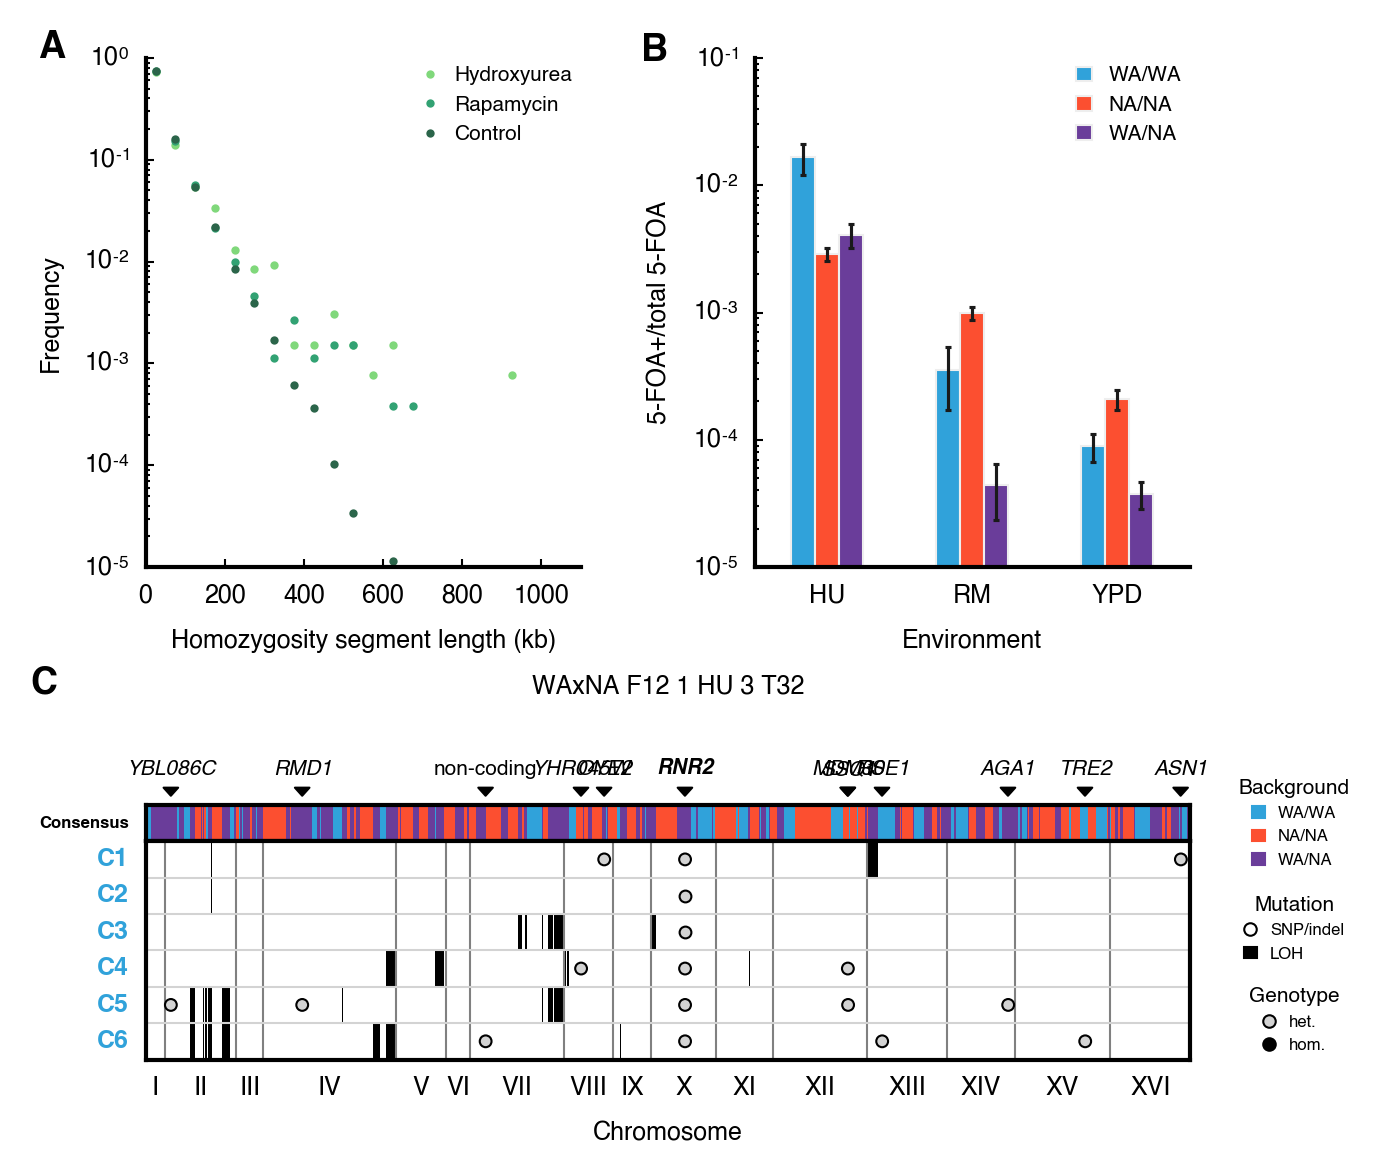

In [8]:
fig = plt.figure(figsize=(4, 6))

grid = gridspec.GridSpec(nrows=3, ncols=2, height_ratios=[2, 1, 1], hspace=0.7, wspace=0.4)

gs = {}
gs['length'] = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=grid[0,0])
gs['fluctuation'] = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=grid[0,1])
gs['loh'] = gridspec.GridSpecFromSubplotSpec(7, 1, subplot_spec=grid[1,:], hspace=0)

### top left panel ###
ax1 = plt.subplot(gs['length'][:])
ax1.text(-0.185, 1.055, 'A', transform=ax1.transAxes,
         fontsize=9, fontweight='bold', va='top', ha='right')

colors = [config.selection['color'][e] for e in loh_length_df.columns]

loh_length_df.rename(columns=config.selection['short_label'])\
.plot(ax=ax1, logy=True, color=colors, style='.', marker='o', ms=2., mec='none', legend=False)

utils.simple_axes(ax1)
ax1.set_xlim(0,1.1E3)
ax1.set_xlabel('Homozygosity segment length (kb)')
ax1.set_ylabel('Frequency')

ax1.legend(frameon=False, loc='upper right', 
           borderaxespad=0., prop={'size':5},
           handlelength=0.75)

### top right panel ###
ax2 = plt.subplot(gs['fluctuation'][:])
ax2.text(-0.2, 1.05, 'B', transform=ax2.transAxes,
         fontsize=9, fontweight='bold', va='top', ha='right')

colors = [config.background['color'][b] for b in loh_fluctuation_df['LOH rate','mean'].columns] 
loh_fluctuation_df['LOH rate','mean'].plot(ax=ax2, kind='bar', yerr = loh_fluctuation_df['LOH rate','sem'], 
                  color=colors, legend=False,
                  error_kw=dict(ecolor='0.1', lw=.75, capsize=.75, capthick=.75))

utils.simple_axes(ax2)
ax2.set_yscale('log')
ax2.set_xlabel('Environment')
ax2.set_xticklabels(loh_fluctuation_df.index.get_level_values('environment'), minor=False, rotation=0)
ax2.set_ylabel('5-FOA+/total 5-FOA')

ax2.legend(frameon=False, loc='upper right', 
           borderaxespad=0., prop={'size':5},
           handlelength=0.75)

### bottom panel ###
ax3 = plt.subplot(gs['loh'][:1])
ax4 = plt.subplot(gs['loh'][1:])
ax4.text(-0.085, 1.8, 'C', transform=ax4.transAxes,
         fontsize=9, fontweight='bold', va='top', ha='right')

# make a color map of fixed colors
cmap = mpl.colors.ListedColormap([config.background['color']['NA/NA'], 
                                  config.background['color']['WA/NA'], 
                                  config.background['color']['WA/WA']])
bounds = [0,1,2]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

seq_dn_df_sliced = pd.pivot_table(seq_dn_df, 
                                  index=['selection','population','time','set','clone','lineage','type'], 
                                  columns=['chr_arabic','chr_roman','pos','gene'])['genotype']

sdn = seq_dn_df_sliced.ix['HU','WAxNA_F12_1_HU_3',32]

### consensus genotype ###
indexer = [slice(None)]*len(sdn.index.names)
indexer[sdn.index.names.index('type')] = ['consensus']
gc = sdn.loc[tuple(indexer),:].dropna(axis=1, how='all')

x = gc.columns.get_level_values('pos').values
y = np.arange(len(gc.index))
data = gc.values

plot.heatmap(np.r_[x, x.max()+1], np.r_[y, y.max()+1], data, 
             ax3, '', '', '', [], [], cmap=cmap, vmin=0, vmax=2)

ax3.set_title('WAxNA F12 1 HU 3 T32', fontsize=6, y=3.5)

ylabels = ['Consensus']
ax3.set_yticks(np.arange(len(ylabels)) + 0.5, minor=True)
ax3.set_yticklabels(ylabels, fontweight='bold', va='center', minor=True)

### de novo mutations ###
indexer = [slice(None)]*len(sdn.index.names)
indexer[sdn.index.names.index('type')] = ['de novo']
gn_all = sdn.loc[tuple(indexer),:].dropna(axis=1, how='all')
        
labels = gn_all.columns.get_level_values('gene')
loc = zip(gn_all.columns.get_level_values('pos'), [-.25]*gn_all.shape[1])

for l, xy in zip(labels, loc):
    trans = ax3.get_xaxis_transform() # x in data units, y in axes fraction
    ann = ax3.annotate(l, xy=xy, xytext=(0, 4), textcoords='offset points',
                       arrowprops=dict(arrowstyle='wedge,tail_width=0.7', color='black'),
                       fontsize=5, style=('italic' if l!='non-coding' else 'normal'), 
                       weight=('bold' if l in ['RNR2','RNR4','FPR1','TOR1'] else 'normal'),
                       annotation_clip=False, va='bottom', ha='center')

for i,(k,g) in enumerate(gn_all.groupby(level='clone')):
    g = g.dropna(axis=1)
    x = g.columns.get_level_values('pos').values
    y = [i+.5]*len(x)
    data = g.values.flatten()
    ax4.scatter(x, y, 
                facecolors=[config.genotype['color'][int(gt)] for gt in data],
                edgecolors='k', s=8, zorder=3)

### LOH ###
indexer = [slice(None)]*len(sdn.index.names)
indexer[sdn.index.names.index('type')] = ['loh']
gl = sdn.loc[tuple(indexer),:].dropna(axis=1, how='all')

x = gl.columns.get_level_values('pos').values
y = np.arange(len(gl.index.get_level_values('clone')))
data = gl.values

# make a color map of fixed colors
cmap = mpl.colors.ListedColormap(['k','w','k'])
bounds = [-1,0,1]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

plot.heatmap(np.r_[x, x.max()+1], np.r_[y, y.max()+1], data, 
             ax4, '', '', '', [], [], cmap=cmap, vmin=data.min(), vmax=data.max())

lineage = gl.index.get_level_values('lineage').unique()[0]
ax4.tick_params(axis='y', colors=config.lineages[lineage]['fill'], width=5, which='both')

# set labels
xlabels = chr_coords.chr_start + (chr_coords.chr_end - chr_coords.chr_start)/2.
xstart = chr_coords.chr_start
ax4.set_xticks(xlabels)
ax4.set_xticklabels(chr_coords.chr_arabic.apply(utils.int_to_roman))
xgrid=[xst+1. for xst in list(set(xstart))]
[ax4.axvline(g, lw=0.5, ls="-", color="gray") for g in xgrid]

ylabels = gl.index.get_level_values('clone').map(str)
ax4.set_yticks(np.arange(len(ylabels)) + 0.5)
ax4.set_yticklabels('C' + ylabels, fontweight='bold', va='center')
[ax4.axhline(g, lw=0.5, ls="-", color="lightgray") for g in np.arange(len(ylabels))]

ax4.set_xlabel('Chromosome')

# set legend    
wt_artist = patches.Rectangle((0,0), width=1, height=1, color=config.background['color']['WA/WA'])
hom_artist = patches.Rectangle((0,0), width=1, height=1, color=config.background['color']['NA/NA'])
het_artist = patches.Rectangle((0,0), width=1, height=1, color=config.background['color']['WA/NA'])

leg1 = ax3.legend([wt_artist,hom_artist,het_artist], ['WA/WA','NA/NA','WA/NA'], 
                  bbox_to_anchor=(1.1, 0.5), ncol=1,
                  frameon=False, loc='center',
                  borderaxespad=0, handlelength=0.75, 
                  title='Background', prop={'size':4})

snp_indel_artist = lines.Line2D((0,1),(0,0), mec='k', mfc=config.genotype['color'][0], 
                                marker='o', markersize=3, linestyle='')
loh_artist = patches.Rectangle((0,0), width=1, height=1, color='k')
    
leg2 = ax4.legend([snp_indel_artist,loh_artist], ['SNP/indel','LOH'], 
                  bbox_to_anchor=(1.1, 0.6), ncol=1,
                  frameon=False, loc='center',
                  borderaxespad=0, handlelength=0.75, 
                  title='Mutation', prop={'size':4})
    
het_artist = lines.Line2D((0,1),(0,0), mec='k', mfc=config.genotype['color'][1], 
                          marker='o', markersize=3, linestyle='')
hom_artist = lines.Line2D((0,1),(0,0), mec='k', mfc=config.genotype['color'][2],
                          marker='o', markersize=3, linestyle='')
    
leg3 = ax4.legend([het_artist,hom_artist], ['het.','hom.'], 
                  bbox_to_anchor=(1.1, 0), ncol=1,
                  frameon=False, loc='lower center',
                  borderaxespad=0, handlelength=0.75, 
                  title='Genotype', prop={'size':4})

ax4.add_artist(leg2)
        
for leg in [leg1,leg2,leg3]:
    plt.setp(leg.get_title(),fontsize=5)

# axes limits
for ax in fig.get_axes():
    ax.xaxis.label.set_size(6)
    ax.yaxis.label.set_size(6)
    ax.tick_params(axis='both', which='major', size=2, labelsize=6)
    ax.tick_params(axis='both', which='minor', size=1, labelsize=4)

fig.savefig(dir_paper+'figures/figure3/figure3.png', bbox_inches='tight')
fig.savefig(dir_paper+'figures/figure3/figure3.svg', bbox_inches='tight')
plt.show()

In [52]:
def loh_length(data, ax=None):
    
    colors = [config.selection['color'][e] for e in loh_length_df.columns]
    
    loh_length_df.rename(columns=config.selection['short_label'])\
    .plot(ax=ax, logy=True, color=colors, style='.', marker='o', ms=2., mec='none', legend=False)

    utils.simple_axes(ax)
    ax.set_xlim(0,1.1E3)
    ax.set_xlabel('Homozygosity segment length (kb)')
    ax.set_ylabel('Frequency')

    ax.legend(frameon=False, loc='upper right', 
              borderaxespad=0., prop={'size':5},
              handlelength=0.75)

def loh_fluctuation(data, ax=None):
    
    colors = [config.background['color'][b] for b in data['LOH rate','mean'].columns] 
    data['LOH rate','mean'].plot(ax=ax, kind='bar', yerr = data['LOH rate','sem'], 
                                 color=colors, legend=False,
                                 error_kw=dict(ecolor='0.1', lw=.75, capsize=.75, capthick=.75))

    utils.simple_axes(ax)
    ax.set_yscale('log')
    ax.set_xlabel('Environment')
    ax.set_xticklabels(data.index.get_level_values('environment'), minor=False, rotation=0)
    ax.set_ylabel('5-FOA+/total 5-FOA')

    ax.legend(frameon=False, loc='upper right', 
              borderaxespad=0., prop={'size':5},
              handlelength=0.75)

def genome_instability(data, gs):
    
    ax1 = plt.subplot(gs[:1])
    ax2 = plt.subplot(gs[1:])
#     ax4.text(-0.085, 1.8, 'C', transform=ax4.transAxes,
#              fontsize=9, fontweight='bold', va='top', ha='right')
    
    ### consensus genotype ###
    indexer = [slice(None)]*len(sdn.index.names)
    indexer[data.index.names.index('type')] = ['consensus']
    consensus_data = data.loc[tuple(indexer),:].dropna(axis=1, how='all')

    x = consensus_data.columns.get_level_values('pos').values
    y = np.arange(len(consensus_data.index))
    consensus_data = consensus_data.values
    
    # make a color map of fixed colors
    cmap = mpl.colors.ListedColormap([config.background['color']['NA/NA'], 
                                      config.background['color']['WA/NA'], 
                                      config.background['color']['WA/WA']])
    bounds = [0,1,2]
    norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
    
    plot.heatmap(np.r_[x, x.max()+1], np.r_[y, y.max()+1], consensus_data, 
                 ax1, '', '', '', [], [], cmap=cmap, vmin=0, vmax=2)

    ax1.set_title('WAxNA F12 1 HU 3 T32', fontsize=6, y=3.5)

    ylabels = ['Consensus']
    ax1.set_yticks(np.arange(len(ylabels)) + 0.5, minor=True)
    ax1.set_yticklabels(ylabels, fontweight='bold', va='center', minor=True)

    ### de novo mutations ###
    indexer = [slice(None)]*len(data.index.names)
    indexer[data.index.names.index('type')] = ['de novo']
    de_novo_data = data.loc[tuple(indexer),:].dropna(axis=1, how='all')
        
    labels = de_novo_data.columns.get_level_values('gene')
    loc = zip(de_novo_data.columns.get_level_values('pos'), [-.25]*de_novo_data.shape[1])

#     for l, xy in zip(labels, loc):
#         trans = ax1.get_xaxis_transform() # x in data units, y in axes fraction
#         ann = ax1.annotate(l, xy=xy, xytext=(0, 4), textcoords='offset points',
#                            arrowprops=dict(arrowstyle='wedge,tail_width=0.7', color='black'),
#                            fontsize=5, style=('italic' if l!='non-coding' else 'normal'), 
#                            weight=('bold' if l in ['RNR2','RNR4','FPR1','TOR1'] else 'normal'),
#                            annotation_clip=False, va='bottom', ha='center')

#     for i,(k,g) in enumerate(de_novo_data.groupby(level='clone')):
#         g = g.dropna(axis=1)
#         x = g.columns.get_level_values('pos').values
#         y = [i+.5]*len(x)
#         data = g.values.flatten()
#         ax2.scatter(x, y, 
#                     facecolors=[config.genotype['color'][int(gt)] for gt in data],
#                     edgecolors='k', s=8, zorder=3)

    ### LOH ###
    indexer = [slice(None)]*len(data.index.names)
    indexer[data.index.names.index('type')] = ['loh']
    loh_data = data.loc[tuple(indexer),:].dropna(axis=1, how='all')

    x = loh_data.columns.get_level_values('pos').values
    y = np.arange(len(loh_data.index.get_level_values('clone')))
    loh_data = loh_data.values

    # make a color map of fixed colors
    cmap = mpl.colors.ListedColormap(['k','w','k'])
    bounds = [-1,0,1]
    norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

    plot.heatmap(np.r_[x, x.max()+1], np.r_[y, y.max()+1], loh_data, 
                 ax2, '', '', '', [], [], cmap=cmap, vmin=loh_data.min(), vmax=loh_data.max())

#     lineage = loh_data.index.get_level_values('lineage').unique()[0]
#     ax2.tick_params(axis='y', colors=config.lineages[lineage]['fill'], width=5, which='both')

    # set labels
    xlabels = chr_coords.chr_start + (chr_coords.chr_end - chr_coords.chr_start)/2.
    xstart = chr_coords.chr_start
    ax2.set_xticks(xlabels)
    ax2.set_xticklabels(chr_coords.chr_arabic.apply(utils.int_to_roman))
    xgrid=[xst+1. for xst in list(set(xstart))]
    [ax2.axvline(g, lw=0.5, ls="-", color="gray") for g in xgrid]

    ylabels = gl.index.get_level_values('clone').map(str)
    ax2.set_yticks(np.arange(len(ylabels)) + 0.5)
    ax2.set_yticklabels('C' + ylabels, fontweight='bold', va='center')
    [ax2.axhline(g, lw=0.5, ls="-", color="lightgray") for g in np.arange(len(ylabels))]

    ax2.set_xlabel('Chromosome')
    
    # set legend    
    wt_artist = patches.Rectangle((0,0), width=1, height=1, color=config.background['color']['WA/WA'])
    hom_artist = patches.Rectangle((0,0), width=1, height=1, color=config.background['color']['NA/NA'])
    het_artist = patches.Rectangle((0,0), width=1, height=1, color=config.background['color']['WA/NA'])

    leg1 = ax1.legend([wt_artist,hom_artist,het_artist], ['WA/WA','NA/NA','WA/NA'], 
                      bbox_to_anchor=(1.1, 0.5), ncol=1,
                      frameon=False, loc='center',
                      borderaxespad=0, handlelength=0.75, 
                      title='Background', prop={'size':4})

    snp_indel_artist = lines.Line2D((0,1),(0,0), mec='k', mfc=config.genotype['color'][0], 
                                    marker='o', markersize=3, linestyle='')
    loh_artist = patches.Rectangle((0,0), width=1, height=1, color='k')
    
    leg2 = ax2.legend([snp_indel_artist,loh_artist], ['SNP/indel','LOH'], 
                      bbox_to_anchor=(1.1, 0.6), ncol=1,
                      frameon=False, loc='center',
                      borderaxespad=0, handlelength=0.75, 
                      title='Mutation', prop={'size':4})
    
    het_artist = lines.Line2D((0,1),(0,0), mec='k', mfc=config.genotype['color'][1], 
                              marker='o', markersize=3, linestyle='')
    hom_artist = lines.Line2D((0,1),(0,0), mec='k', mfc=config.genotype['color'][2],
                              marker='o', markersize=3, linestyle='')
    
    leg3 = ax2.legend([het_artist,hom_artist], ['het.','hom.'], 
                      bbox_to_anchor=(1.1, 0), ncol=1,
                      frameon=False, loc='lower center',
                      borderaxespad=0, handlelength=0.75, 
                      title='Genotype', prop={'size':4})

    ax2.add_artist(leg2)
        
    for leg in [leg1,leg2,leg3]:
        plt.setp(leg.get_title(),fontsize=5)

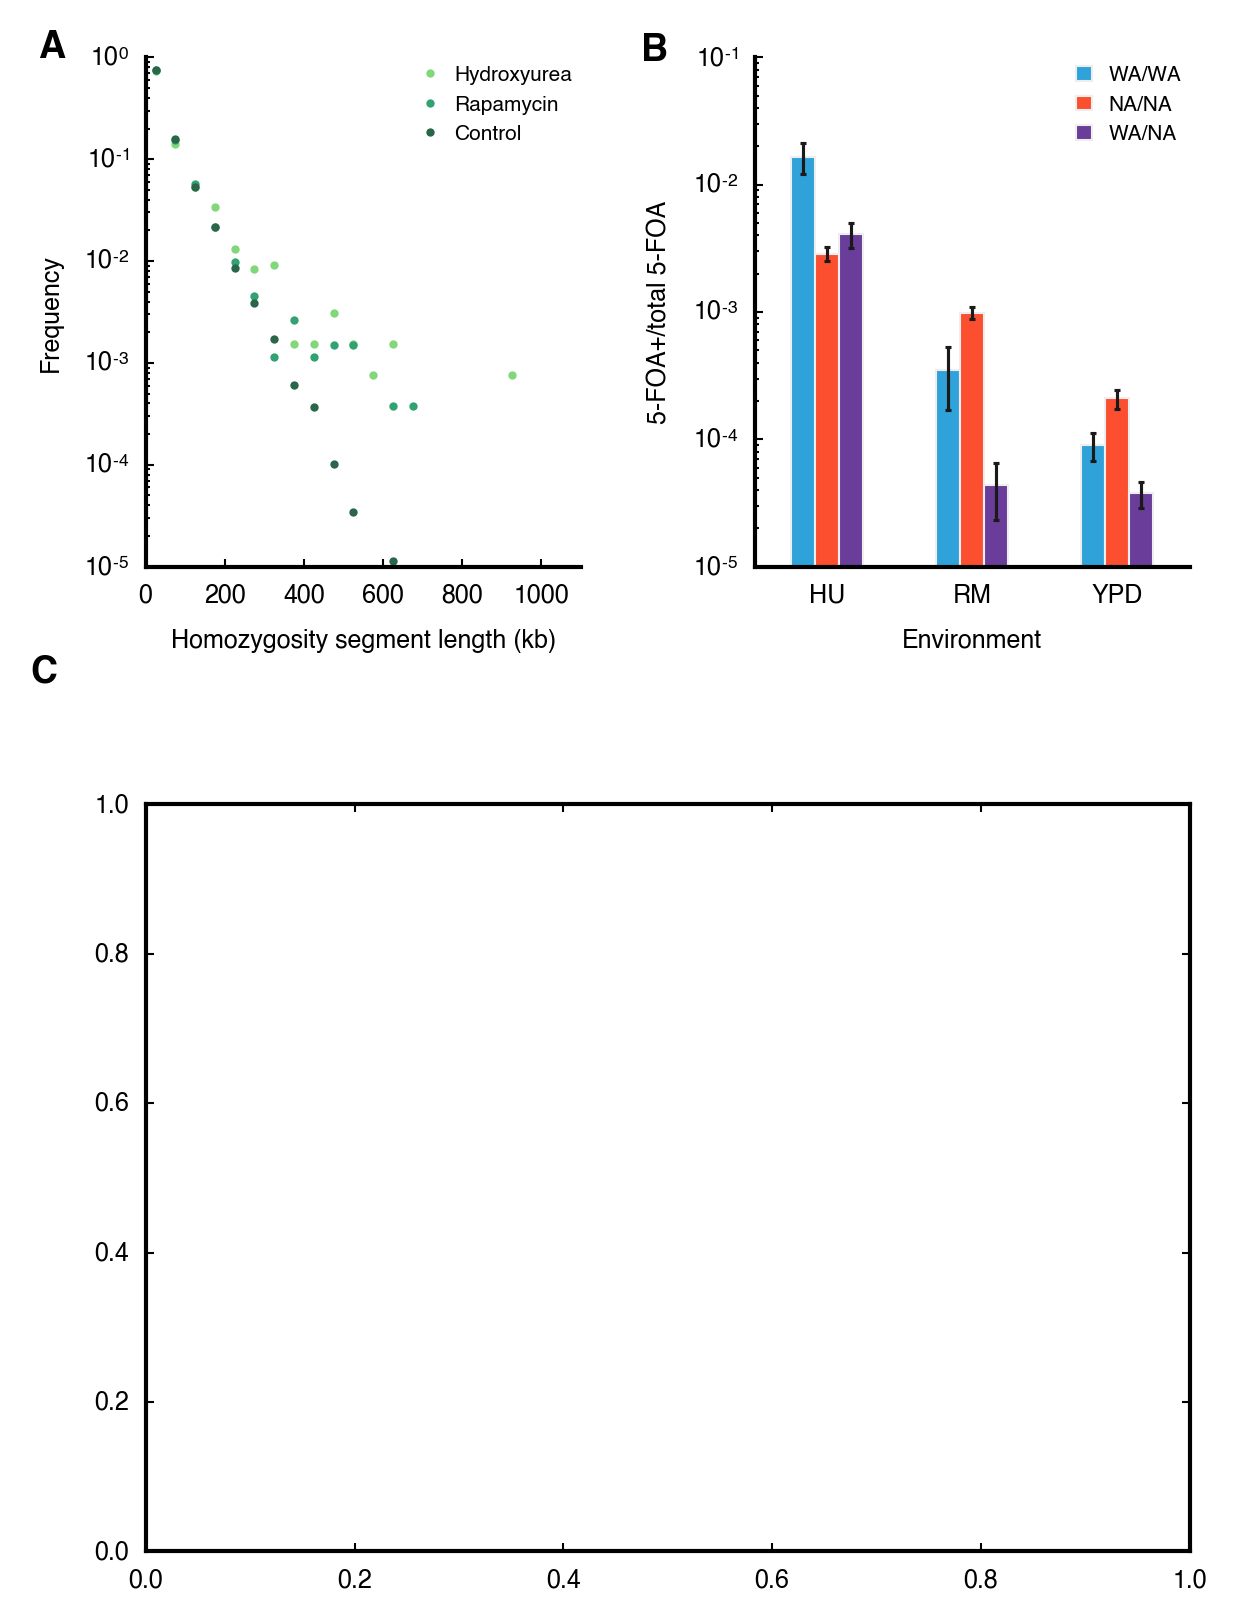

In [55]:
fig = plt.figure(figsize=(4, 6))

grid = gridspec.GridSpec(nrows=3, ncols=2, height_ratios=[2, 1, 1], hspace=0.7, wspace=0.4)

gs = {}
gs['length'] = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=grid[0,0])
gs['fluctuation'] = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=grid[0,1])
gs['loh'] = gridspec.GridSpecFromSubplotSpec(14, 1, subplot_spec=grid[1:,:], hspace=0)

### top left panel ###
ax = plt.subplot(gs['length'][:])
ax.text(-0.185, 1.055, 'A', transform=ax.transAxes,
        fontsize=9, fontweight='bold', va='top', ha='right')

loh_length(loh_length_df, ax)

### top right panel ###
ax = plt.subplot(gs['fluctuation'][:])
ax.text(-0.2, 1.05, 'B', transform=ax.transAxes,
        fontsize=9, fontweight='bold', va='top', ha='right')

loh_fluctuation(loh_fluctuation_df, ax)

### bottom panel ###
seq_dn_df_sliced = pd.pivot_table(seq_dn_df, 
                                  index=['selection','population','time','set','clone','lineage','type'], 
                                  columns=['chr_arabic','chr_roman','pos','gene'])['genotype']

ax = plt.subplot(gs['loh'][:])
ax.text(-0.085, 1.2, 'C', transform=ax.transAxes,
        fontsize=9, fontweight='bold', va='top', ha='right')

sdn = seq_dn_df_sliced.ix['HU','WAxNA_F12_1_HU_3',32]
# genome_instability(sdn, ax)
sdn = seq_dn_df_sliced.ix['RM','WAxNA_F12_1_RM_3',32]
# genome_instability(sdn, ax)

# axes limits
for ax in fig.get_axes():
    ax.xaxis.label.set_size(6)
    ax.yaxis.label.set_size(6)
    ax.tick_params(axis='both', which='major', size=2, labelsize=6)
    ax.tick_params(axis='both', which='minor', size=1, labelsize=4)

fig.savefig(dir_paper+'figures/figure3/figure3.png', bbox_inches='tight')
fig.savefig(dir_paper+'figures/figure3/figure3.svg', bbox_inches='tight')
plt.show()

**Fig. 3:** Pervasive genome instability. (**A**) The length distribution of homozygous segments, in bins corresponding to 50-kb increments, shows an excess of long homozygosity tracts above 300 kb in hydroxyurea and rapamycin (KS-test, $P<0.01$). Ancestral haploid isolates are used to compare a set of *in silico* diploid genomes to evolved diploid isolates. Only unrelated isolate backgrounds were included. (**B**) Background- and environment-dependent rates of loss-of-heterozygosity were measured in a fluctuation assay by loss of the URA3 marker. 5-FOA+ colonies indicate loss of the marker. LOH rates were elevated in hydroxyurea compared to the control environment and manifested background-dependent effects between the parents and their hybrid. The mean frequency of 5-FOA+ colony-forming units (c.f.u.) is shown. Error bars indicate the standard error of the mean. (**C**) Consensus genotype of six related isolates from the WAxNA F12 1 HU 3 population, each carrying a shared *RNR2* heterozygous mutation (circles) and private regions with LOH (segments). Chromosome II has undergone extensive LOH in isolates C5 and C6, which have 13% faster growth rate compared to C1-C4 (Fig. 2C, middle).

## Figure S5 - Sequences of ancestral clones

/Users/ivg/.virtualenvs/gv-paper-2016/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


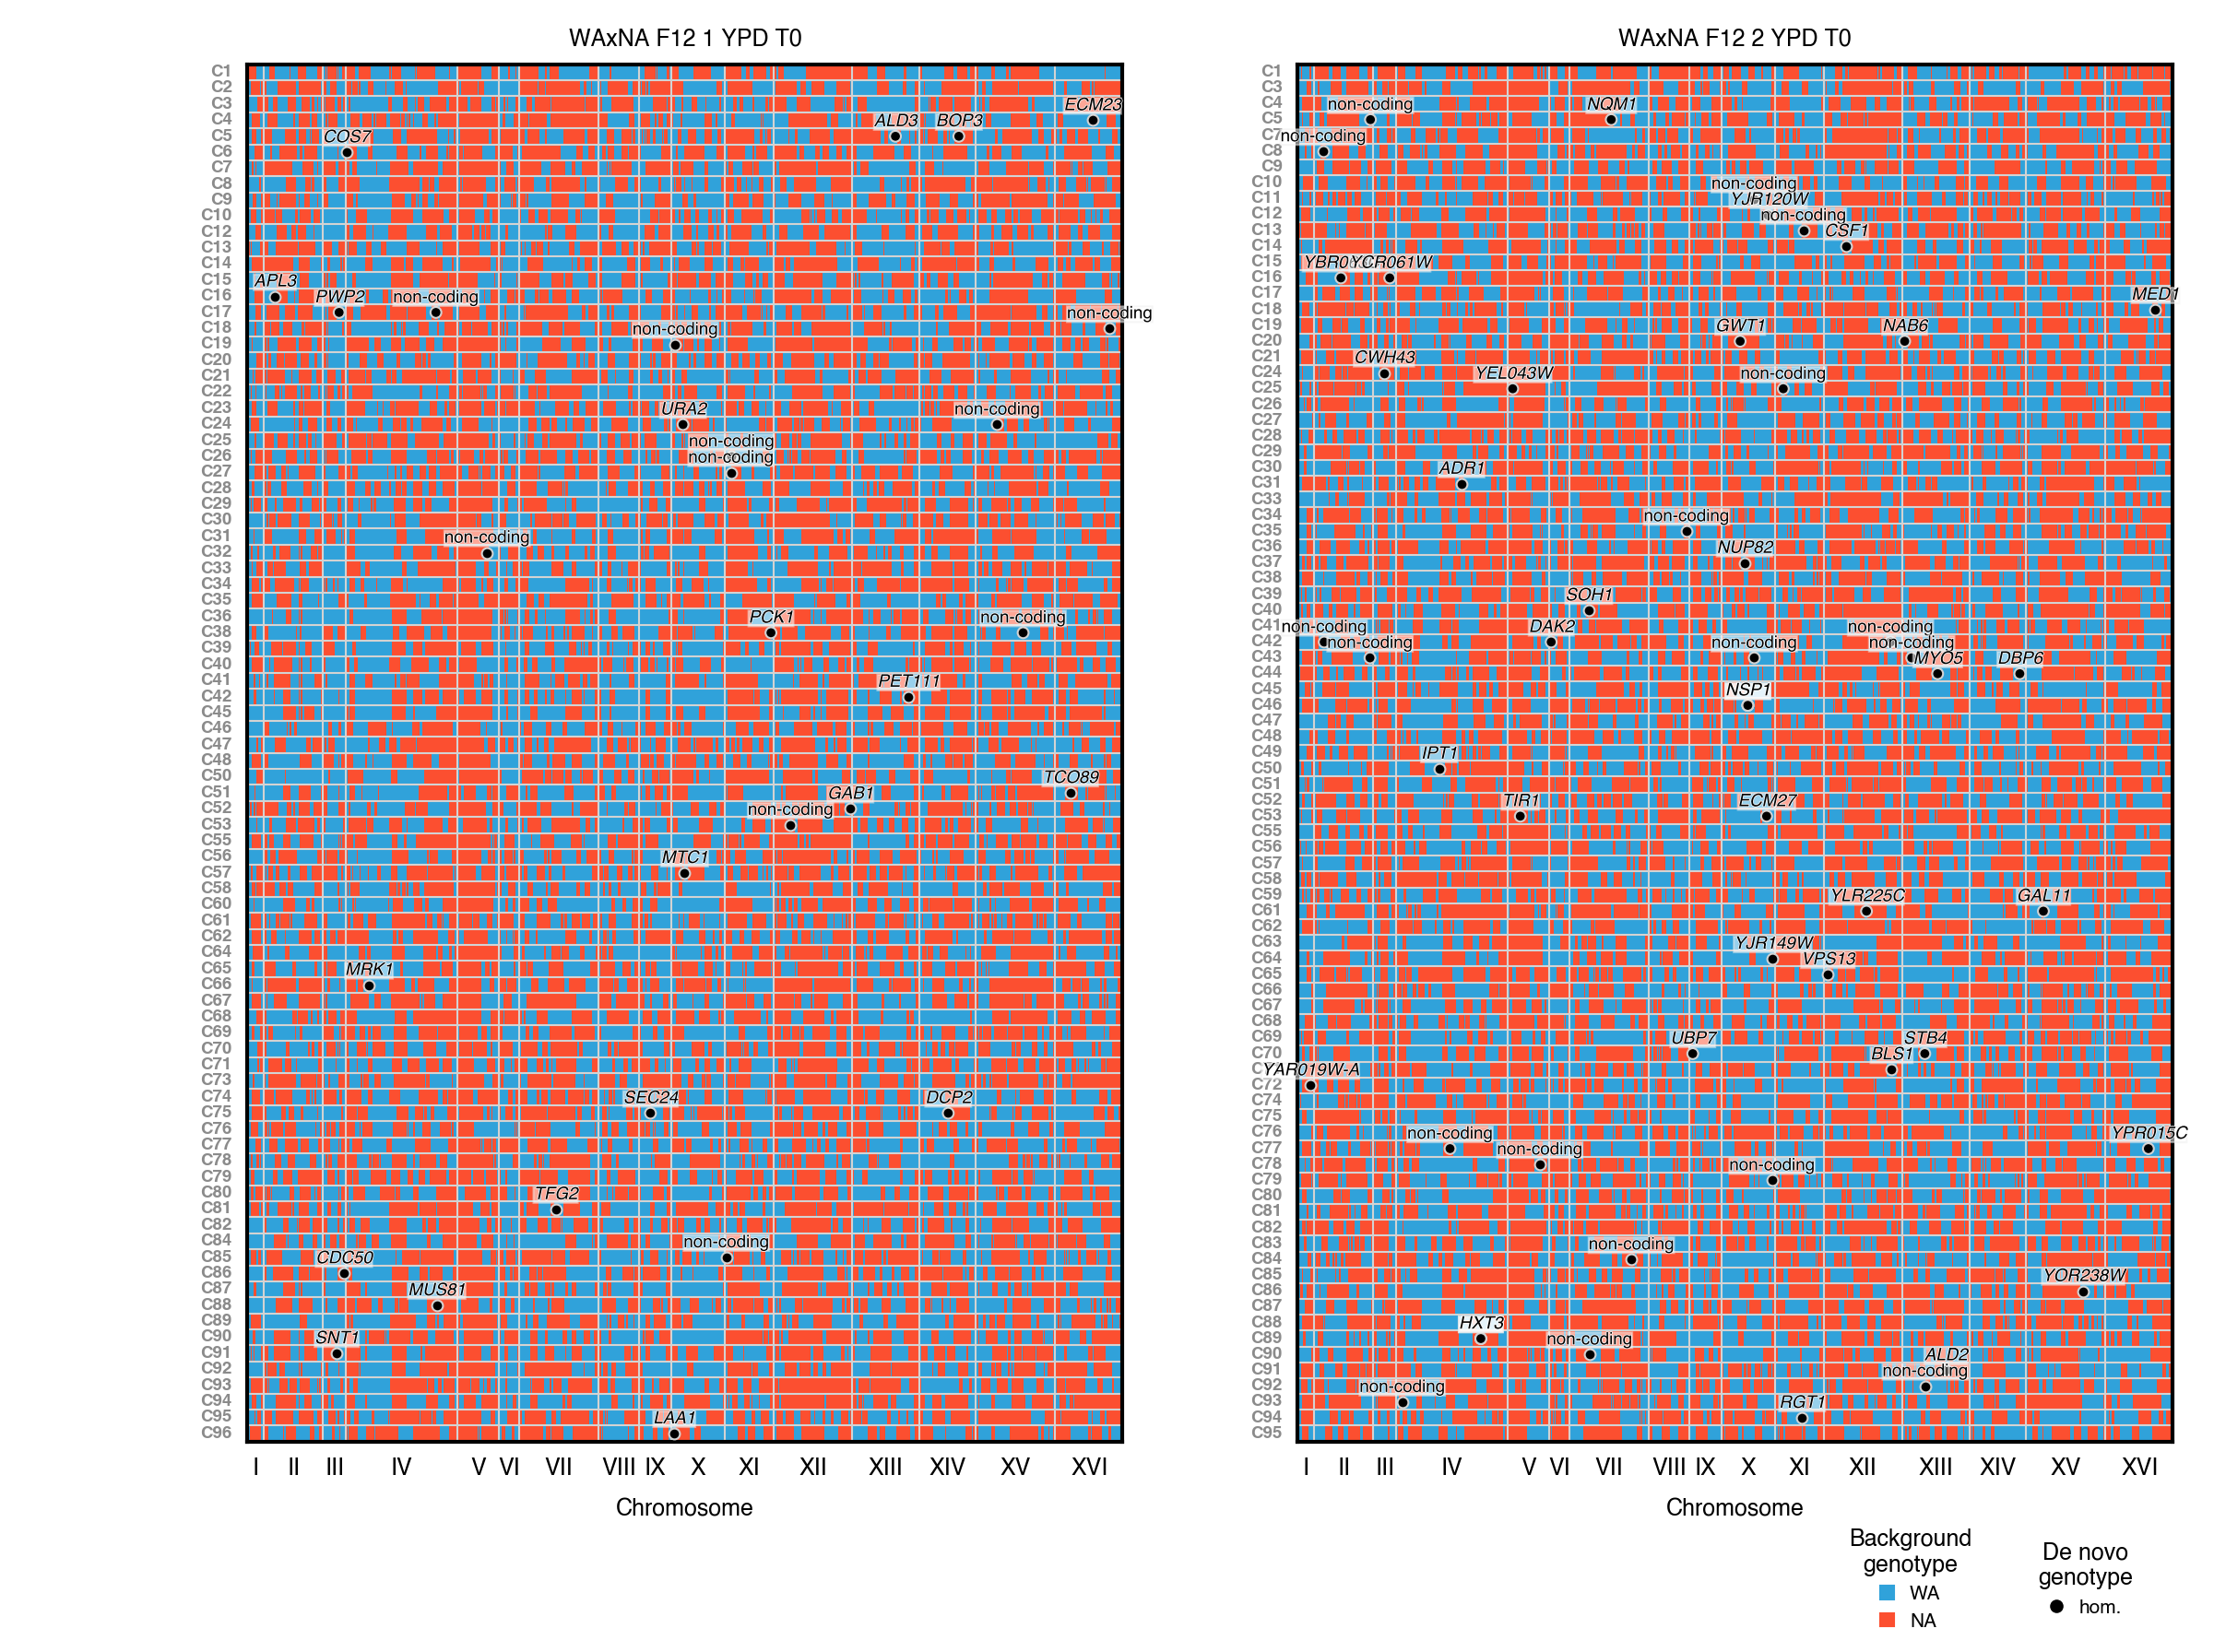

In [59]:
# keep ancestral haploid isolates only
seq_dn_df_sliced = seq_dn_df[(seq_dn_df['type'].isin(['genotype','de novo'])) & \
                             (seq_dn_df['time']==0) & \
                             (seq_dn_df['ploidy']=='haploid')]

seq_dn_df_sliced['clone'] = seq_dn_df_sliced['clone'].astype(int)
seq_dn_df_sliced = seq_dn_df_sliced.sort_values('clone')

seq_dn_df_sliced = pd.pivot_table(seq_dn_df_sliced, 
                                  index=['selection','population','time','set','clone','lineage','type'], 
                                  columns=['chr_arabic','chr_roman','pos','gene'])['genotype']

fig = plt.figure(figsize=(8, 6))

shape = pd.DataFrame({k: 
x.shape for k,x in seq_dn_df_sliced.groupby(level=['population'])
})

grid = gridspec.GridSpec(1, 2, wspace=0.2)
gs = {}

for ii, (p, sdf) in enumerate(seq_dn_df_sliced.groupby(level=['population'])):

    nrows = 1
    ncols = 1
    gs[p] = gridspec.GridSpecFromSubplotSpec(nrows, ncols,
                                             subplot_spec=grid[ii],
                                             hspace=0, wspace=0)
    
    # retrieve axis
    ax = plt.subplot(gs[p][:])
    
    ### background genotype ###
    indexer = [slice(None)]*len(sdf.index.names)
    indexer[sdf.index.names.index('type')] = ['genotype']
    gt = sdf.loc[tuple(indexer),:].dropna(axis=1, how='all')
            
    x = gt.columns.get_level_values('pos').values
    y = np.arange(len(gt.index))
    data = gt.fillna(method='pad', axis=1).values
        
    # make a color map of fixed colors
    cmap = mpl.colors.ListedColormap([config.background['color']['NA'], 
                                      config.background['color']['WA']])
    bounds = [0,1]
    norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
    
    title = ''
    xlabel= ''
    ylabel= ''
    xticklabels = []
    yticklabels = []
        
    plot.heatmap(np.r_[x, x.max()+1], np.r_[y, y.max()+1], data,
                 ax, title, xlabel, ylabel, xticklabels, yticklabels, cmap=cmap, 
                 vmin=np.nanmin(data), vmax=np.nanmax(data), speed='fast')

    # set title
    ax.set_title(p.replace('_',' ')+' T0', fontsize=6)
    
    # set ticks
    lineage = gt.index.get_level_values('lineage').unique()[0]
    ax.tick_params(axis='y', colors=config.lineages[lineage]['fill'], width=5, which='both')
    
    ### de novo genotype ###
    indexer = [slice(None)]*len(sdf.index.names)
    indexer[sdf.index.names.index('type')] = ['de novo']
    gn = sdf.loc[tuple(indexer),:].dropna(axis=1, how='all')
        
    if len(gn) > 0:
                
        for i,(k,g) in enumerate(gn.groupby(level='clone')):

            g = g.dropna(axis=1)
            x = g.columns.get_level_values('pos').values
            y = np.repeat(g.index.get_level_values('clone').values+.5, len(x))
            data = g.values.flatten()
            ax.scatter(x, y,
                       facecolors=[config.genotype['color'][d] for d in data],
                       edgecolors='lightgray', s=8, zorder=3)
            
            genes = g.columns.get_level_values('gene')
            loc = zip(x, y-.4)
            
            for l, xy in zip(genes, loc):

                ann = ax.annotate(l, xy=xy, xytext=(0, 0), textcoords='offset points',
                                  bbox=dict(boxstyle="round,pad=0", fc="w", alpha=0.5),
                                  fontsize=4.5, va='bottom', ha='center',
                                  color='k', style=('italic' if l!='non-coding' else 'normal'),
                                  path_effects=[PathEffects.withStroke(linewidth=0.35, foreground='w')])

    # set grid
    xlabels = chr_coords.chr_start + (chr_coords.chr_end - chr_coords.chr_start)/2.
    xstart = chr_coords.chr_start
    ax.set_xticks(xlabels, minor=False)
    ax.set_xticklabels(chr_coords.chr_arabic.apply(utils.int_to_roman), minor=False)
    ax.set_xlabel('Chromosome')
    xgrid=[xst+1. for xst in list(set(xstart))]
    [ax.axvline(g, lw=0.5, ls="-", color="lightgray") for g in xgrid]
    
    ylabels = gt.index.get_level_values('clone').map(str)
    ax.set_yticks(np.arange(len(ylabels)) + 0.5, minor=False)
    ax.set_yticklabels('C' + ylabels, fontweight='bold', va='center', minor=False)
    [ax.axhline(g, lw=0.5, ls="-", color="lightgray") for g in np.arange(len(ylabels))]

# set legend
for k, xy in zip(['WAxNA_F12_2_YPD'],[(2,0),(2,0)]):
    
    ax = plt.subplot(gs[k][:])
    
    wt_artist = patches.Rectangle((0,0), width=1, height=1, color=config.background['color']['WA'])
    hom_artist = patches.Rectangle((0,0), width=1, height=1, color=config.background['color']['NA'])
    
    leg1 = ax.legend([wt_artist,hom_artist], 
                     ['WA','NA'], 
                     bbox_to_anchor=(0.7, -0.1), ncol=1,
                     frameon=False, loc='center',
                     borderaxespad=0, handlelength=0.75, 
                     title='Background\ngenotype', prop={'size':5})
    
    hom_artist = lines.Line2D((0,1),(0,0), mec='k', mfc=config.genotype['color'][2],
                              marker='o', markersize=3, linestyle='')
    
    leg2 = ax.legend([hom_artist], 
                     ['hom.'], 
                     bbox_to_anchor=(0.9, -0.1), ncol=1,
                     frameon=False, loc='center',
                     borderaxespad=0, handlelength=0.75, 
                     title='De novo\ngenotype', prop={'size':5})
    
    ax.add_artist(leg1)
        
    for leg in [leg1,leg2]:
        plt.setp(leg.get_title(),fontsize=6, multialignment='center')

for ax in fig.get_axes():
    ax.xaxis.label.set_size(6)
    ax.yaxis.label.set_size(6)
    ax.tick_params(axis='x', which='major', size=2, labelsize=6)
    ax.tick_params(axis='y', which='major', size=2, labelsize=4.5)
    ax.tick_params(axis='both', which='minor', size=1, labelsize=4)

# fig.savefig(dir_supp+'figures/supp_figure_seq_clones/supp_figure_seq_ancestral_clones.pdf', bbox_inches='tight')
fig.savefig(dir_supp+'figures/supp_figure_seq_clones/supp_figure_seq_ancestral_clones.png', bbox_inches='tight')
# fig.savefig(dir_supp+'figures/supp_figure_seq_clones/supp_figure_seq_ancestral_clones.svg', bbox_inches='tight')
plt.show()

**Fig. S5:** Sequences of ancestral clones sampled from the WAxNA $\text{F}_\text{12}$ founder populations, which were obtained by bulk crossing between the WA and NA parents. Pre-existing and *de novo* SNPs and indels were detected by whole-genome sequencing in single-cell derived clones from ancestral populations at ${t\,{=}\,0}$ days. Chromosomes are shown on the $x$-axis; clone isolates are listed on the left. WA (in blue) and NA (in red) represent haploid genotypes. Individual cells with unique background genotypes carry private *de novo* SNPs and indels (circles).

## Figure S6 - Genome instability in sequences of evolved clones

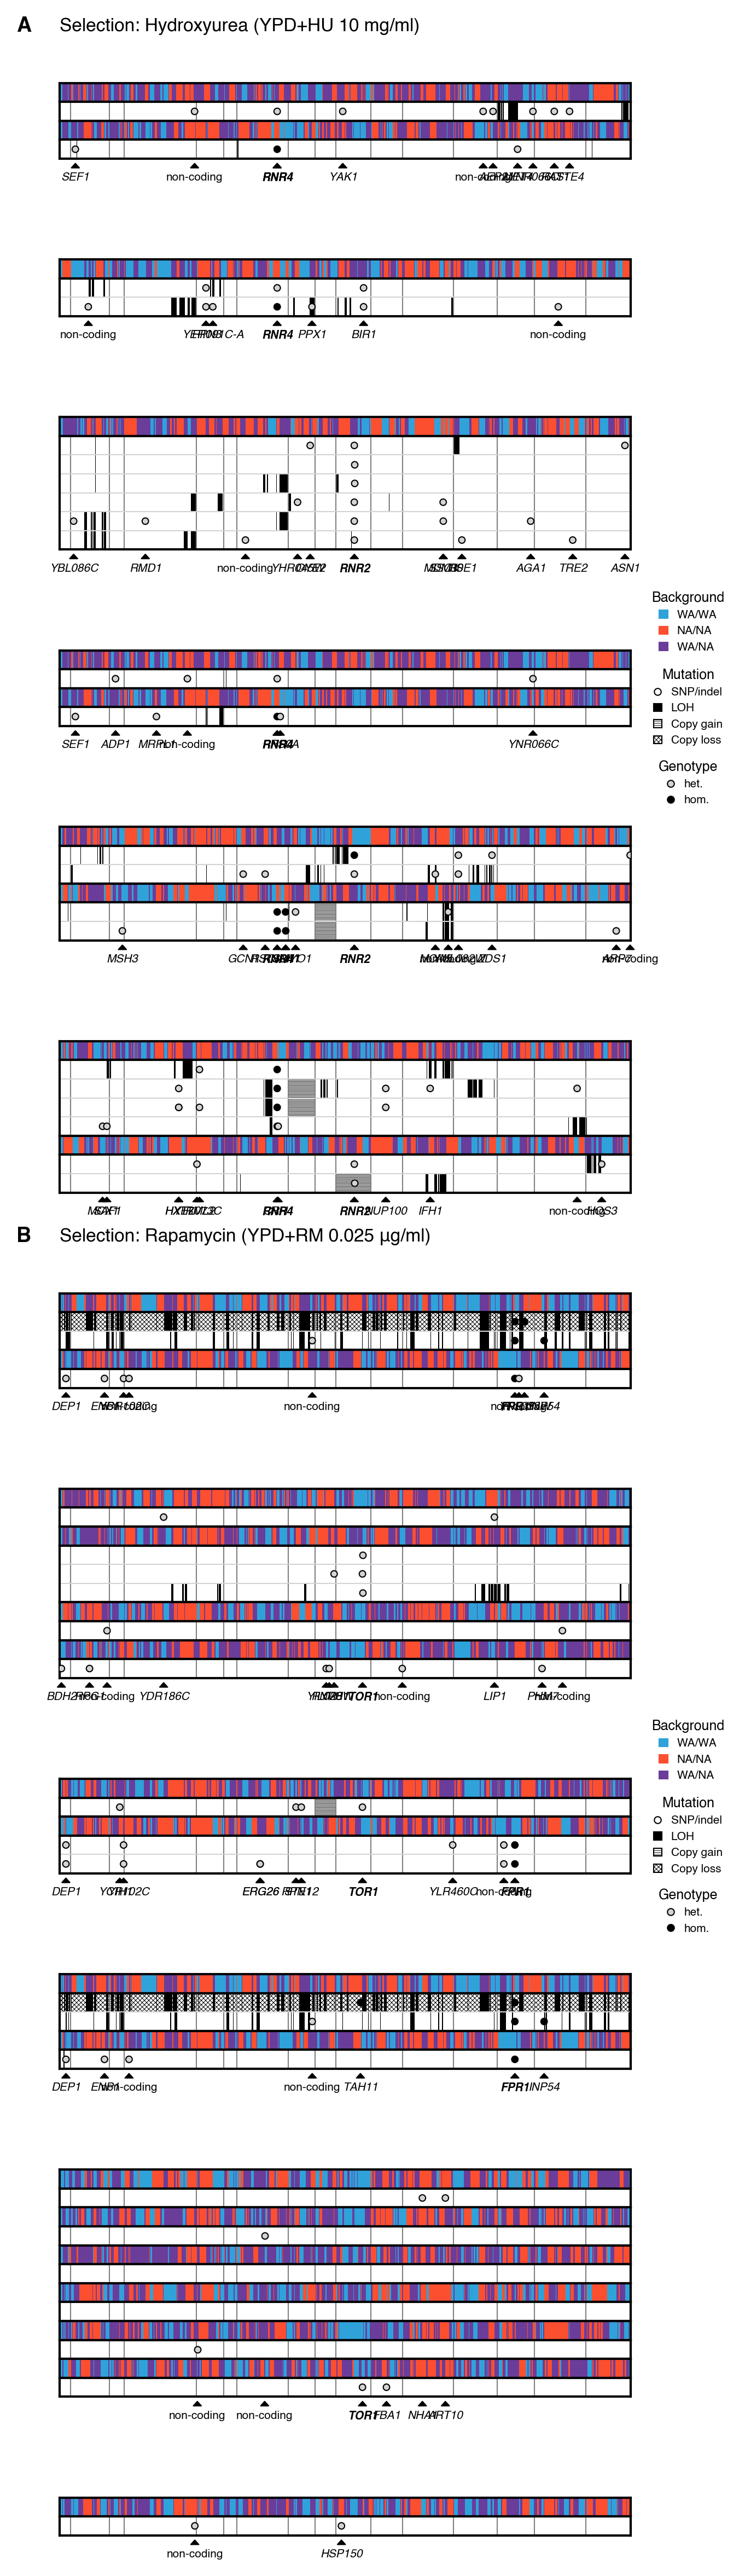

In [60]:
# keep evolved isolates only
seq_dn_df_sliced = seq_dn_df[(seq_dn_df['type'].isin(['consensus','copy_number','loh','de novo'])) & \
                             (seq_dn_df['time']==32)]

seq_dn_df_sliced = pd.pivot_table(seq_dn_df_sliced, 
                                  index=['selection','population','time','set','clone','lineage','type','ploidy'], 
                                  columns=['chr_arabic','chr_roman','pos','gene'])['genotype']

fig = plt.figure(figsize=(4, 18))

indexer = [slice(None)]*len(seq_dn_df_sliced.index.names)
indexer[seq_dn_df_sliced.index.names.index('type')] = ['consensus','loh']
seq_dn_df_shape = seq_dn_df_sliced.loc[tuple(indexer),:].dropna(axis=1, how='all')

shape = pd.DataFrame({k: 
x.shape for k,x in seq_dn_df_shape.groupby(level=['selection','population'])
})

ygrid = shape.ix[0].values
grid = gridspec.GridSpec(len(ygrid), 1, height_ratios=ygrid, hspace=0.9)

gs = {}

for ii, ((e,p), sdf) in enumerate(seq_dn_df_sliced.groupby(level=['selection','population'])):

    idx = 0
    
    nrows = ygrid[ii]
    ncols = 1
    gs[(e,p)] = gridspec.GridSpecFromSubplotSpec(nrows, ncols,
                                                 subplot_spec=grid[ii],
                                                 hspace=0, wspace=0)
    
    for jj, (s, jdf) in enumerate(sdf.groupby(level='set')):
        
        ### consensus genotype ###
        indexer = [slice(None)]*len(jdf.index.names)
        indexer[jdf.index.names.index('type')] = ['consensus']
        gc = jdf.loc[tuple(indexer),:].dropna(axis=1, how='all')
        
        ax1 = plt.subplot(gs[(e,p)][idx:idx+len(gc)])

        idx += len(gc)
        
        # set title
        ax1.set_title(p)
        
        if len(gc) > 0:
            x = gc.columns.get_level_values('pos').values
            y = np.arange(len(gc.index))
            data = gc.values
            
            # make a color map of fixed colors
            cmap = mpl.colors.ListedColormap([config.background['color']['NA'], 
                                              config.background['color']['WAxNA'], 
                                              config.background['color']['WA']])
            bounds = [0,1,2]
            norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
            
            title = ''
            xlabel= ''
            ylabel= ''
            xticklabels = []
            yticklabels = []
    
            plot.heatmap(np.r_[x, x.max()+1], np.r_[y, y.max()+1], data, 
                         ax1, title, xlabel, ylabel, xticklabels, yticklabels, cmap=cmap, vmin=data.min(), vmax=data.max())
        
            ax1.set_title(title, fontsize=6)
              
        ### LOH ###
        indexer = [slice(None)]*len(jdf.index.names)
        indexer[jdf.index.names.index('type')] = ['loh']
        gl = jdf.loc[tuple(indexer),:].dropna(axis=1, how='all')
        
        ax2 = plt.subplot(gs[(e,p)][idx:idx+len(gl)], sharex=ax1)
        idx += len(gl)
        
        if len(gl) > 0:
            x = gl.columns.get_level_values('pos').values
            y = np.arange(len(gl.index))
            data = gl.values
    
            # make a color map of fixed colors
            cmap = mpl.colors.ListedColormap(['k','w','k'])
            bounds = [-1,0,1]
            norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

            plot.heatmap(np.r_[x, x.max()+1], np.r_[y, y.max()+1], data, 
                         ax2, '', '', '', [], [], cmap=cmap, vmin=-1, vmax=1)
            
            lineage = gl.index.get_level_values('lineage').unique()[0]
            ax2.tick_params(axis='y', colors=config.lineages[lineage]['fill'], width=5, which='both')

        ### copy number ###
        indexer = [slice(None)]*len(jdf.index.names)
        indexer[jdf.index.names.index('type')] = ['copy_number']
        gc = jdf.loc[tuple(indexer),:].dropna(axis=1, how='all')
                
        if len(gc) > 0:

            x = gc.columns.get_level_values('pos').values
            y = np.arange(len(gc.index.get_level_values('clone')))
            data = gc.values
                    
            cmap = mpl.colors.ListedColormap(['none','w','none'])
            bounds = [1,2,3]
            norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
                    
            for cn, hatch in zip([1, 3], ['xxx','-----']):
            
                plot.heatmap(np.r_[x, x.max()+1], np.r_[y, y.max()+1], 
                             np.ma.masked_array(data, data!=cn), 
                             ax2, '', '', '', [], [], cmap=cmap, hatch=hatch, vmin=1, vmax=3)
        
        ### de novo mutations ###
        indexer = [slice(None)]*len(jdf.index.names)
        indexer[jdf.index.names.index('type')] = ['de novo']
        gn = jdf.loc[tuple(indexer),:].dropna(axis=1, how='all')
        
        if len(gn) > 0:
            
            for i,(k,g) in enumerate(gn.groupby(level='clone')):
                g = g.dropna(axis=1)
                x = g.columns.get_level_values('pos').values
                y = [i+.5]*len(x)
                data = g.values.flatten()
                ax2.scatter(x, y, 
                            facecolors=[config.genotype['color'][gt] for gt in data],
                            edgecolors='k', s=8, zorder=3)

        # set grid
        xlabels = chr_coords.chr_start + (chr_coords.chr_end - chr_coords.chr_start)/2.
        xstart = chr_coords.chr_start
        if ii<(len(seq_loh_df.index)-1):
            ax2.set_xticks([])
            ax2.set_xticklabels([])
        else:
            ax2.set_xticks(xlabels, minor=False)
            ax2.set_xticklabels(chr_coords.chr_arabic.apply(utils.int_to_roman), minor=False)
            ax2.set_xlabel('Chromosome')
        xgrid=[xst+1. for xst in list(set(xstart))]
        [ax2.axvline(g, lw=0.5, ls="-", color="gray") for g in xgrid]
    
        ylabels = gl.index.get_level_values('clone').map(str)
        ax2.set_yticks(np.arange(len(ylabels)) + 0.5, minor=False)
#         ax2.set_yticklabels('C' + ylabels, fontweight='bold', va='center', minor=False)
        [ax2.axhline(g, lw=0.5, ls="-", color="lightgray") for g in np.arange(len(ylabels))]
    
    # annotate de novo mutations
    indexer = [slice(None)]*len(sdf.index.names)
    indexer[sdf.index.names.index('type')] = ['de novo']
    gn_all = sdf.loc[tuple(indexer),:].dropna(axis=1, how='all')
        
    genes = gn_all.columns.get_level_values('gene')
    loc = zip(gn_all.columns.get_level_values('pos'), [gn.shape[0]+.25]*gn_all.shape[1])

    for l, xy in zip(genes, loc):     
        trans = ax2.get_xaxis_transform() # x in data units, y in axes fraction
        ann = ax2.annotate(l, xy=xy, xytext=(0, -4), textcoords='offset points',
                           arrowprops=dict(arrowstyle='wedge,tail_width=0.7', color='black'),
                           fontsize=5, annotation_clip=False, va='top', ha='center',
                           style=('italic' if l!='non-coding' else 'normal'), 
                           weight=('bold' if l in ['RNR2','RNR4','FPR1','TOR1'] else 'normal'))

# set panel labels
ax1 = plt.subplot(gs['HU','WAxNA_F12_1_HU_1'][(0,0)])
ax1.text(-0.05, 4,  chr(ord('A')), transform=ax1.transAxes,
         fontsize=9, fontweight='bold', va='center', ha='right')
ax1.text(0, 4, 'Selection: %s' % config.selection['long_label']['HU'], 
         transform=ax1.transAxes, fontsize=8, va='center', ha='left')

ax1 = plt.subplot(gs['RM','WAxNA_F12_1_RM_1'][(0,0)])
ax1.text(-0.05, 4,  chr(ord('B')), transform=ax1.transAxes,
         fontsize=9, fontweight='bold', va='center', ha='right')
ax1.text(0, 4, 'Selection: %s' % config.selection['long_label']['RM'],
         transform=ax1.transAxes, fontsize=8, va='center', ha='left')

# set legend
for k, xy in zip([('HU','WAxNA_F12_2_HU_1'),('RM','WAxNA_F12_1_RM_3')],[(2,0),(2,0)]):
    
    ax3 = plt.subplot(gs[k][(0,0)])
    
    wt_artist = patches.Rectangle((0,0), width=1, height=1, color=config.background['color']['WA/WA'])
    het_artist = patches.Rectangle((0,0), width=1, height=1, color=config.background['color']['WA/NA'])
    hom_artist = patches.Rectangle((0,0), width=1, height=1, color=config.background['color']['NA/NA'])
    
    leg1 = ax3.legend([wt_artist,hom_artist,het_artist], 
                      ['WA/WA','NA/NA','WA/NA'], 
                      bbox_to_anchor=(1.1, 2.5), ncol=1,
                      frameon=False, loc='center',
                      borderaxespad=0, handlelength=0.75, 
                      title='Background', prop={'size':5})
    
    ax4 = plt.subplot(gs[k][(2,0)])
    
    snp_indel_artist = lines.Line2D((0,1),(0,0), mec='k', mfc='w', marker='o', markersize=3, linestyle='')
    loh_artist = patches.Rectangle((0,0), width=1, height=1, color='k')
    cn_gain_artist = patches.Rectangle((0,0), width=1, height=1, color='k', hatch='---', fill=False)
    cn_loss_artist = patches.Rectangle((0,0), width=1, height=1, color='k', hatch='xxx', fill=False)
    
    leg2 = ax4.legend([snp_indel_artist,loh_artist,cn_gain_artist,cn_loss_artist], 
                      ['SNP/indel','LOH','Copy gain','Copy loss'], 
                      bbox_to_anchor=(1.1, 0.0), ncol=1,
                      frameon=False, loc='center',
                      borderaxespad=0, handlelength=0.75, 
                      title='Mutation', prop={'size':5})
    
    het_artist = lines.Line2D((0,1),(0,0), mec='k', mfc=config.genotype['color'][1], 
                              marker='o', markersize=3, linestyle='')
    hom_artist = lines.Line2D((0,1),(0,0), mec='k', mfc=config.genotype['color'][2],
                              marker='o', markersize=3, linestyle='')
    
    leg3 = ax4.legend([het_artist,hom_artist], 
                      ['het.','hom.'], 
                      bbox_to_anchor=(1.1, -4), ncol=1,
                      frameon=False, loc='center',
                      borderaxespad=0, handlelength=0.75, 
                      title='Genotype', prop={'size':5})
    
    ax4.add_artist(leg2)
    
    for leg in [leg1,leg2,leg3]:
        plt.setp(leg.get_title(),fontsize=6)
    
# axes limits
for ax in fig.get_axes():
    ax.xaxis.label.set_size(6)
    ax.yaxis.label.set_size(6)
    ax.tick_params(axis='both', which='major', size=2, labelsize=6)
    ax.tick_params(axis='both', which='minor', size=1, labelsize=4)

fig.savefig(dir_supp+'figures/supp_figure_seq_clones/supp_figure_seq_evolved_clones.pdf', bbox_inches='tight')
fig.savefig(dir_supp+'figures/supp_figure_seq_clones/supp_figure_seq_evolved_clones.png', bbox_inches='tight')
fig.savefig(dir_supp+'figures/supp_figure_seq_clones/supp_figure_seq_evolved_clones.svg', bbox_inches='tight')
plt.show()

**Fig. S6:** Genome instability in sequences of evolved clones. SNPs, indels and chromosome-level aberrations were detected by whole-genome sequencing in single-cell derived clones from evolved populations, after ${t\,{=}\,32}$ days in (**A**) hydroxurea or (**B**) rapamycin (see Table S1). Chromosomes are shown on the $x$-axis; clone isolates are listed on the left, colored by lineage (see Fig. S7). The consensus shows the majority genotype across population isolates with sequence identity greater than 80%. WA/WA (in blue) and NA/NA (in red) represent homozygous diploid genotypes and WA/NA (in purple) represents a heterozygous genotype. Individual cells with shared background genotype carry *de novo* SNPs and indels (circles), *de novo* mis-segregations with loss-of-heterozygosity (solid segments) and *de novo* gains or losses in copy number (hatched segments). Driver and passenger mutations are listed along the bottom (drivers are in boldface). Populations marked by $\otimes$ indicate cross-contamination during the selection phase, but any derived events are independent.

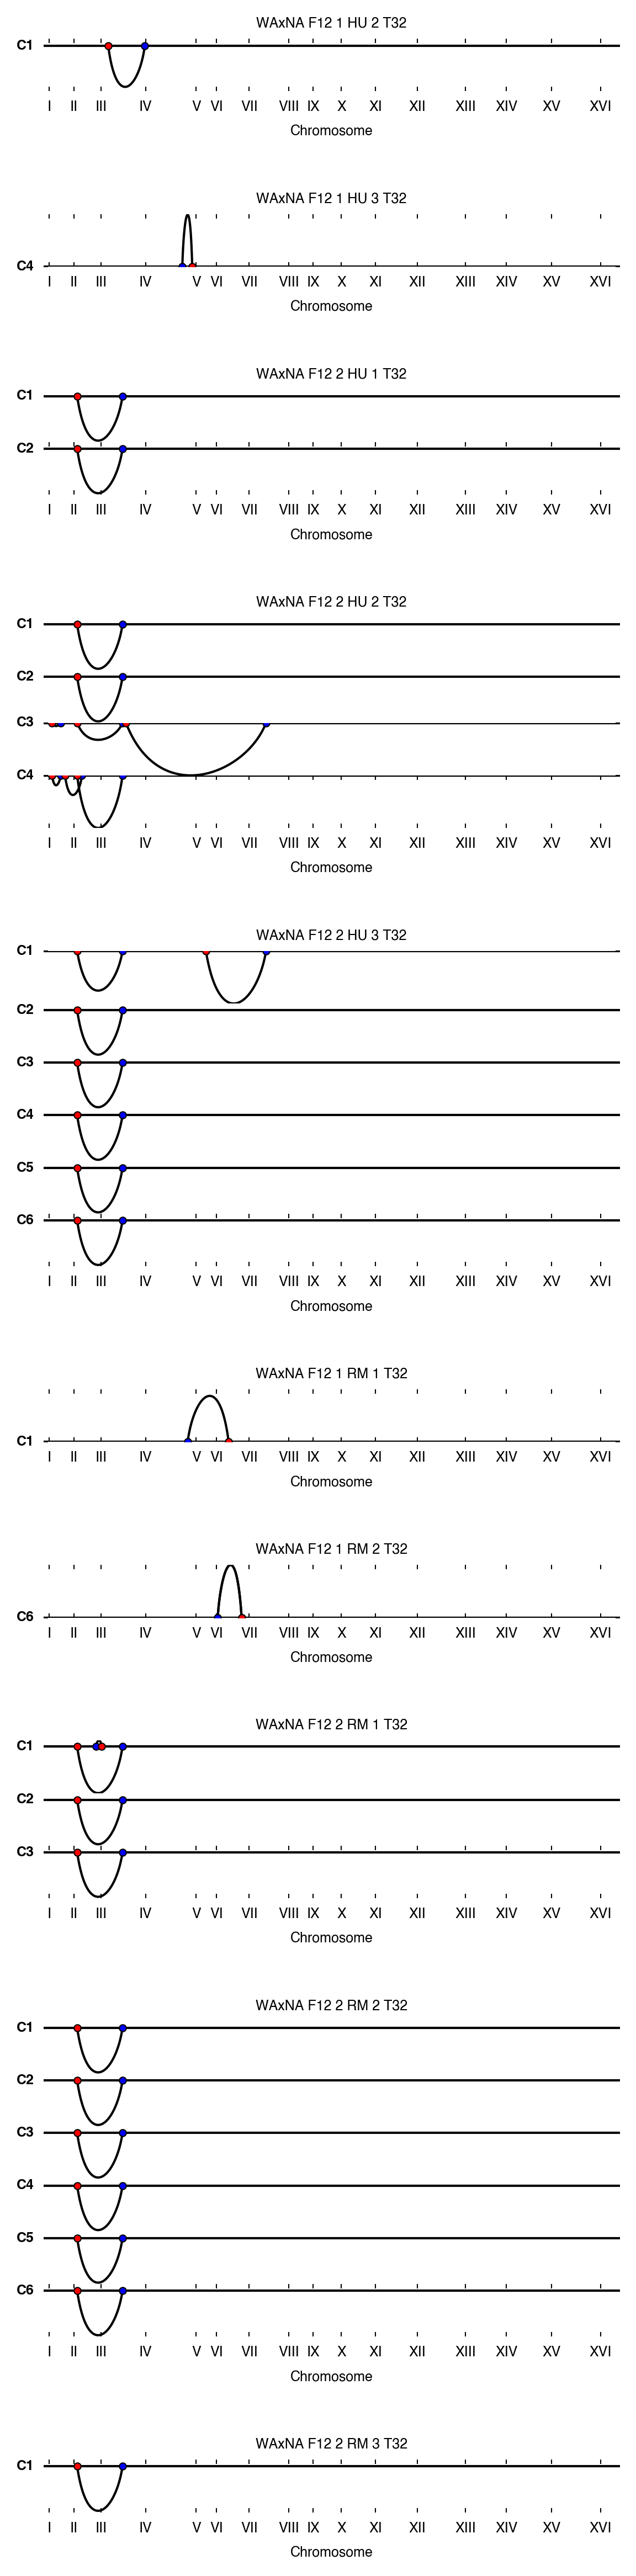

In [17]:
fig = plt.figure(figsize=(4, 18))

shape = seq_sv_df.groupby(['selection','population']).isolate.nunique()

ygrid = shape.values
grid = gridspec.GridSpec(len(ygrid), 1, height_ratios=ygrid, hspace=0.9)

gsp = {}

fig = plt.figure(figsize=(4, 18))

for ii, ((s,p), ge) in enumerate(seq_sv_df.groupby(['selection','population'])):
    
    nrows = ygrid[ii]
    ncols = 1
    
    gsp[(s,p)] = gridspec.GridSpecFromSubplotSpec(nrows, ncols,
                                                 subplot_spec=grid[ii],
                                                 hspace=0, wspace=0)
    
    # Set title
    ax = plt.subplot(gsp[(s,p)][:1])
    ax.set_title(p.replace('_',' '), fontsize=6)
    
    for jj, (isolate, gs) in enumerate(ge.groupby('isolate')):
        
        # Retrieve axis
        ax = plt.subplot(gsp[(s,p)][jj:jj+1])
        # 
        plot.structural_variants(gs, ax, offset=jj)
        # Set tick labels
        ylabels = [isolate]#gl.index.get_level_values('clone').map(str)
        ax.set_yticks(np.arange(len(ylabels)), minor=False)
        ax.set_yticklabels(ylabels, fontweight='bold', va='center', minor=False)

    # set grid
    xlabels = chr_coords.chr_start + (chr_coords.chr_end - chr_coords.chr_start)/2.
    xstart = chr_coords.chr_start
    ax.set_xticks(xlabels, minor=False)
    ax.set_xticklabels(chr_coords.chr_arabic.apply(utils.int_to_roman), minor=False)
    ax.set_xlabel('Chromosome')

# # set legend
# for k, xy in zip([('HU','WAxNA_F12_2_HU_1_T32'),('RM','WAxNA_F12_1_RM_3_T32')],[(2,0),(2,0)]):
    
#     ax3 = plt.subplot(gsp[k][(0,0)])
    
#     deletion_artist = lines.Line2D((0,1),(0,0), **config.variant_type['deletion'])
#     duplication_artist = lines.Line2D((0,1),(0,0), **config.variant_type['duplication'])
#     inversion_artist = lines.Line2D((0,1),(0,0), **config.variant_type['inversion'])
#     transversion_artist = lines.Line2D((0,1),(0,0), **config.variant_type['translocation'])
    
#     leg = ax3.legend([deletion_artist,duplication_artist,inversion_artist,transversion_artist], 
#                      ['Deletion','Duplication','Inversion','Translocation'], 
#                      bbox_to_anchor=(1.1, 0.0), ncol=1,
#                      frameon=False, loc='center',
#                      borderaxespad=0, handlelength=0.75, 
#                      title='Mutation', prop={'size':5})

# axes limits
for ax in fig.get_axes():
    ax.xaxis.label.set_size(6)
    ax.yaxis.label.set_size(6)
    ax.tick_params(axis='both', which='major', size=2, labelsize=6)
    ax.tick_params(axis='both', which='minor', size=1, labelsize=4)
        
fig.savefig(dir_supp+'figures/supp_figure_seq_clones/supp_figure_seq_evolved_clones_sv.pdf', bbox_inches='tight')
fig.savefig(dir_supp+'figures/supp_figure_seq_clones/supp_figure_seq_evolved_clones_sv.png', bbox_inches='tight')
fig.savefig(dir_supp+'figures/supp_figure_seq_clones/supp_figure_seq_evolved_clones_sv.svg', bbox_inches='tight')
plt.show()

In [18]:
seq_sv_df

sample  chr      start  chr2       end  \
variant_type                                                              
TRA          0  WAxNA_F12_1_HU_2_T32_C1   11     2363.0     3  307240.0   
             0  WAxNA_F12_1_HU_3_T32_C4   15   117681.0     5  207152.0   
             0  WAxNA_F12_1_RM_1_T32_C1   15   228203.0     8  389275.0   
             0  WAxNA_F12_1_RM_2_T32_C6   15   854243.0    14   96293.0   
             1  WAxNA_F12_1_RM_2_T32_C6   15   854491.0    14   96349.0   
             0  WAxNA_F12_2_HU_1_T32_C1    5   115941.0     2  473281.0   
             0  WAxNA_F12_2_HU_1_T32_C2    5   115922.0     2  473271.0   
             0  WAxNA_F12_2_HU_2_T32_C1    5   115917.0     2  473290.0   
             0  WAxNA_F12_2_HU_2_T32_C2    5   115928.0     2  473271.0   
             0  WAxNA_F12_2_HU_2_T32_C3    4   359567.0     1  182581.0   
             1  WAxNA_F12_2_HU_2_T32_C3    5   115917.0     2  473263.0   
             2  WAxNA_F12_2_HU_2_T32_C3   16   769228.0     4  359613.0   
             0  WAxNA_F12_2_HU_2_T32_C4    4   359556.0     1  182584.0   
             1  WAxNA_F12_2_HU_2_T32_C4    4   803611.0     2  221430.0   
             2  WAxNA_F12_2_HU_2_T32_C4    5   115924.0     2  473260.0   
             0  WAxNA_F12_2_HU_3_T32_C1    5   115914.0     2  473271.0   
             1  WAxNA_F12_2_HU_3_T32_C1   16   769328.0     5  492405.0   
             0  WAxNA_F12_2_HU_3_T32_C2    5   115917.0     2  473272.0   
             0  WAxNA_F12_2_HU_3_T32_C3    5   115919.0     2  473272.0   
             0  WAxNA_F12_2_HU_3_T32_C4    5   115938.0     2  473271.0   
             0  WAxNA_F12_2_HU_3_T32_C5    5   115917.0     2  473280.0   
             0  WAxNA_F12_2_HU_3_T32_C6    5   115911.0     2  473259.0   
             0  WAxNA_F12_2_RM_1_T32_C1    4  1095468.0     3  169438.0   
             1  WAxNA_F12_2_RM_1_T32_C1    5   115920.0     2  473280.0   
             0  WAxNA_F12_2_RM_1_T32_C2    5   115935.0     2  473271.0   
             0  WAxNA_F12_2_RM_1_T32_C3    5   115942.0     2  473260.0   
             0  WAxNA_F12_2_RM_2_T32_C1    5   115921.0     2  473296.0   
             0  WAxNA_F12_2_RM_2_T32_C2    5   115918.0     2  473280.0   
             0  WAxNA_F12_2_RM_2_T32_C3    5   115918.0     2  473286.0   
             0  WAxNA_F12_2_RM_2_T32_C4    5   115917.0     2  473259.0   
             0  WAxNA_F12_2_RM_2_T32_C5    5   115916.0     2  473283.0   
             0  WAxNA_F12_2_RM_2_T32_C6    5   115931.0     2  473271.0   
             0  WAxNA_F12_2_RM_3_T32_C1    5   115927.0     2  473259.0   

                         id  size  vac       vaf                singleton  \
variant_type                                                                
TRA          0  TRA00002308   0.0  1.0  0.005435  WAxNA_F12_1_HU_2_T32_C1   
             0  TRA00004469   0.0  0.0  0.000000                      NaN   
             0  TRA00004545   0.0  0.0  0.000000                      NaN   
             0  TRA00004992   0.0  1.0  0.005155  WAxNA_F12_1_RM_2_T32_C6   
             1  TRA00005013   0.0  0.0  0.000000                      NaN   
             0  TRA00000455   0.0  1.0  0.005155  WAxNA_F12_2_HU_1_T32_C1   
             0  TRA00000459   0.0  1.0  0.005155  WAxNA_F12_2_HU_1_T32_C2   
             0  TRA00000457   0.0  1.0  0.005155  WAxNA_F12_2_HU_2_T32_C1   
             0  TRA00000457   0.0  1.0  0.005155  WAxNA_F12_2_HU_2_T32_C2   
             0  TRA00000157   0.0  1.0  0.005155  WAxNA_F12_2_HU_2_T32_C3   
             1  TRA00000458   0.0  1.0  0.005155  WAxNA_F12_2_HU_2_T32_C3   
             2  TRA00007577   0.0  1.0  0.005155  WAxNA_F12_2_HU_2_T32_C3   
             0  TRA00000156   0.0  1.0  0.005155  WAxNA_F12_2_HU_2_T32_C4   
             1  TRA00000273   0.0  1.0  0.005208  WAxNA_F12_2_HU_2_T32_C4   
             2  TRA00000458   0.0  1.0  0.005155  WAxNA_F12_2_HU_2_T32_C4   
             0  TRA00000455   0.0  1.0  0.005155  WAxNA_F12_2_HU_3_T32_C1   
             1  TRA00